# Generate mock phenotype data for 1000 Genomes Phase 3 samples
### By [Bruno Ambrozio](https://about.me/bambrozio)
> Notebook based on the script "[make_mock_phenotypes_script](https://app.terra.bio/#workspaces/broad-t2d-dev/Running_GWAS_in_Terra)", maintained by [Terra](https://app.terra.bio/). Kuddos to them!

In [1]:
library(data.table)
set.seed(5)

In [2]:
# load the data from 1kg ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
ped <- fread("../integrated_call_samples_v3.20130502.ALL.panel",
             data.table = F,
             stringsAsFactors = F,
             fill = T)

In [3]:
head(ped[-1,])

,V1,V2,V3,V4,V5,V6
2,HG00096,GBR,EUR,male,NA,NA
3,HG00097,GBR,EUR,female,NA,NA
4,HG00099,GBR,EUR,female,NA,NA
5,HG00100,GBR,EUR,female,NA,NA
6,HG00101,GBR,EUR,male,NA,NA
7,HG00102,GBR,EUR,female,NA,NA


In [4]:
# fix the names
drops <- c("V5", "V6")
ped = ped[ , !(names(ped) %in% drops)]
names(ped) <- c("sample", "subpopulation", "superpopulation", "sex")
ped <- ped[-1,]
row.names(ped) <- 1:nrow(ped)
head(ped)

sample,subpopulation,superpopulation,sex
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male
HG00102,GBR,EUR,female


In [5]:
# What ancestries do we have?
unique(ped$superpopulation)

[1] "EUR" "EAS" "AMR" "SAS" "AFR"

In [6]:
# how many people?
n <- nrow(ped)
n

[1] 2504

In [7]:
# add a age mock column
ped$age <- floor(runif(n, min = 30, max = 99))
head(ped)

sample,subpopulation,superpopulation,sex,age
HG00096,GBR,EUR,male,43
HG00097,GBR,EUR,female,77
HG00099,GBR,EUR,female,93
HG00100,GBR,EUR,female,49
HG00101,GBR,EUR,male,37
HG00102,GBR,EUR,female,78


In [8]:
# add bmi (quantitative phenotype) and t2d (case/control phenotype) mock columns
ped$bmi <- ped$t2d <- 0
head(ped)

sample,subpopulation,superpopulation,sex,age,t2d,bmi
HG00096,GBR,EUR,male,43,0,0
HG00097,GBR,EUR,female,77,0,0
HG00099,GBR,EUR,female,93,0,0
HG00100,GBR,EUR,female,49,0,0
HG00101,GBR,EUR,male,37,0,0
HG00102,GBR,EUR,female,78,0,0


For each ancestry, add t2d columns based on population prevalence. Grounded on:

> Source: [Spanakis, E., & Golden, S. (2013). Race/Ethnic Difference in Diabetes and Diabetic Complications. Current Diabetes Reports, 13(6), 814-823. doi: 10.1007/s11892-013-0421-9](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3830901/#S3title)
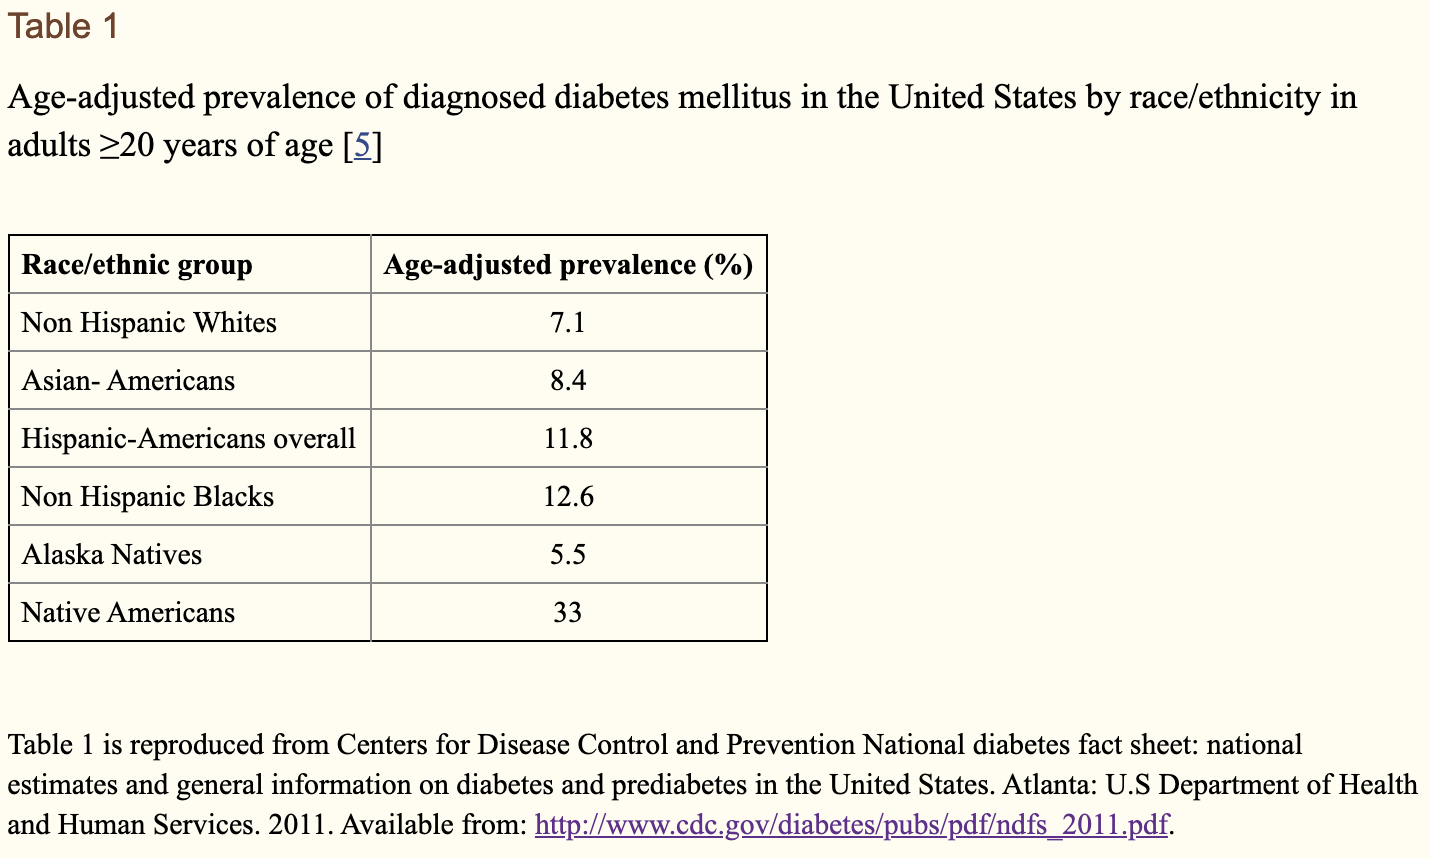

---

> Souce: [Ma, R., & Chan, J. (2013). Type 2 diabetes in East Asians: similarities and differences with populations in Europe and the United States. Annals Of The New York Academy Of Sciences, 1281(1), 64-91. doi: 10.1111/nyas.12098](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3708105/#__sec2title)
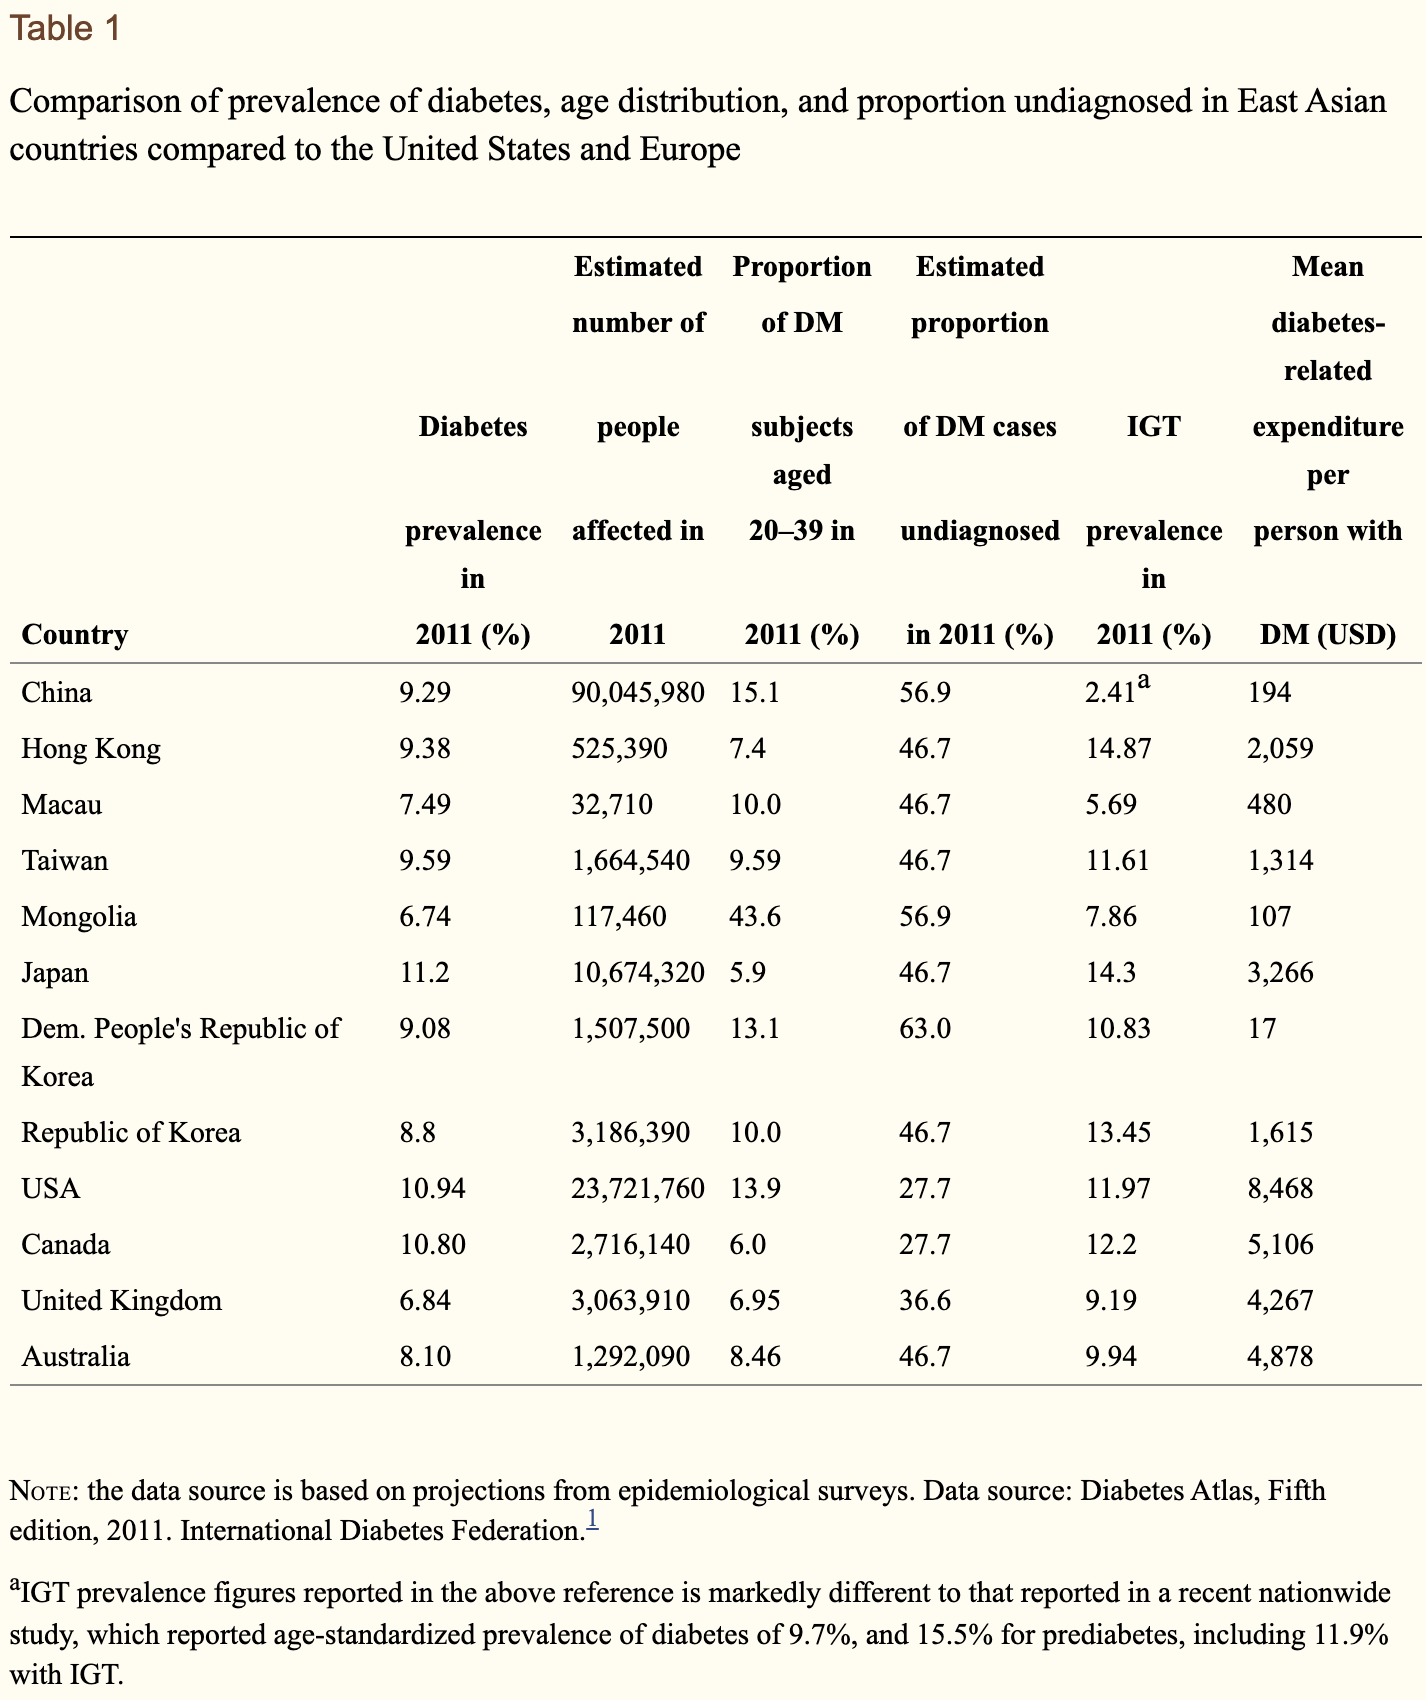

In [9]:
t2d.prev <- data.frame(
  anc = c("EUR", "AMR", "AFR", "EAS", "SAS"),
  prev = c(7.1, 33, 12.6, 8.95, 17),
  case_bmi = c(20, 35, 30, 15, 10),
  control_bmi = c(25, 30, 30, 17, 8),
  stringsAsFactors = F
)
t2d.prev

anc,prev,case_bmi,control_bmi
EUR,7.10,20,25
AMR,33.00,35,30
AFR,12.60,30,30
EAS,8.95,15,17
SAS,17.00,10,8


In [10]:
new.ped <- list()
for (anc in unique(ped$superpopulation)){
  cur.ped <- ped[ped$superpopulation == anc,]
  nn <- nrow(cur.ped)
  ncase <- floor(nn*t2d.prev[t2d.prev$anc == anc, "prev"]/100)
  cur.ped[sample(1:nrow(cur.ped), ncase), "t2d"] <- 1
  cur.ped[cur.ped$t2d == 1, "bmi"] <- rnorm(nrow(cur.ped[cur.ped$t2d == 1,]),
                                            mean = t2d.prev[t2d.prev$anc == anc, "case_bmi"],
                                            sd = 2)
  cur.ped[cur.ped$t2d == 0, "bmi"] <- rnorm(nrow(cur.ped[cur.ped$t2d == 0,]),
                                            mean = t2d.prev[t2d.prev$anc == anc, "control_bmi"],
                                            sd = 2)
  new.ped[[anc]] <- cur.ped
}

ped <- do.call(rbind, new.ped)
ped$sex <- ifelse(ped$sex == "male", "M", "F")

head(ped)

,sample,subpopulation,superpopulation,sex,age,t2d,bmi
EUR.1,HG00096,GBR,EUR,M,43,0,25.42418
EUR.2,HG00097,GBR,EUR,F,77,0,22.79394
EUR.3,HG00099,GBR,EUR,F,93,1,24.48213
EUR.4,HG00100,GBR,EUR,F,49,0,25.46661
EUR.5,HG00101,GBR,EUR,M,37,0,26.27279
EUR.6,HG00102,GBR,EUR,F,78,0,24.76994


In [23]:
fwrite(ped,
       file = paste0('1kg_phenotype_mock_', as.Date(Sys.time(), "%d/%m/%Y"), ".tsv"),
       sep = "\t", row.names = F)